# Import necessary modules 

In [1]:
%matplotlib inline
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from ganrectorch.utils import angles, nor_tomo
from ganrectorch.propagators import RadonTransform
from ganrectorch.models import make_generator
from ganrectorch.ganrec import GANtomo

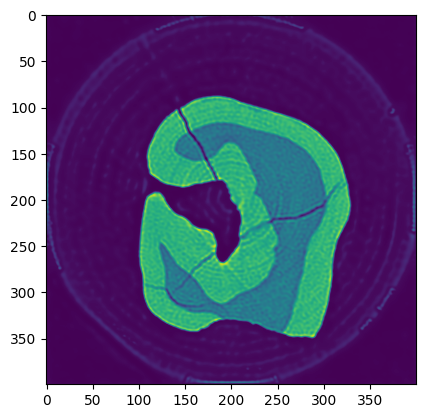

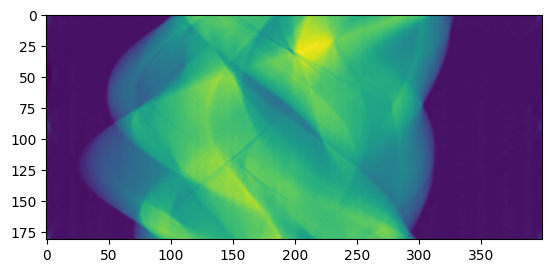

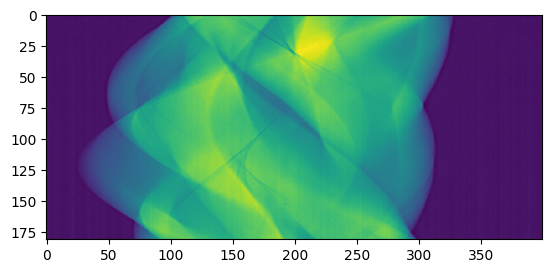

In [2]:
data =tifffile.imread('./test_results/tooth_recon.tiff')
plt.imshow(data)
plt.show()
device = torch.device('cuda')
data = torch.from_numpy(data)
data = data.view(1, 1, 400, 400)
ang = angles(181)

ang = torch.from_numpy(ang)
prj_sim = RadonTransform(data, ang).forward()
# print(prj_sim.shape)
prj_sim = prj_sim.view(181, 400)
prj_sim = prj_sim.numpy()
plt.imshow(prj_sim)
plt.show()

prj = tifffile.imread('./test_data/tooth.tiff')
nang, px = prj.shape
ang = angles(nang)
prj = nor_tomo(prj)
plt.imshow(prj)
plt.show()


In [18]:
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self, img_h, img_w, conv_num, conv_size, dropout, output_num):
        super(Generator, self).__init__()
        units_out = 128
        self.img_w = img_w
        self.img_h = img_h

        # Calculate the size after the fully connected layers
        input_size = img_w * img_h
        fc_size = img_w**2

        self.fc_stack = nn.Sequential(
            self.dense_norm(input_size, units_out, dropout),
            self.dense_norm(units_out, units_out, dropout),
            self.dense_norm(units_out, units_out, dropout),
            self.dense_norm(units_out, fc_size, 0)
        )

        self.conv_stack = nn.Sequential(
            self.conv2d_norm(1, conv_num, conv_size+2, 1),
            self.conv2d_norm(conv_num, conv_num, conv_size+2, 1),
            self.conv2d_norm(conv_num, conv_num, conv_size, 1),
        )

        self.dconv_stack = nn.Sequential(
            self.dconv2d_norm(conv_num, conv_num, conv_size+2, 1),
            self.dconv2d_norm(conv_num, conv_num, conv_size+2, 1),
            self.dconv2d_norm(conv_num, conv_num, conv_size, 1),
        )

        self.last = nn.Sequential(
            nn.Conv2d(conv_num, output_num, 3, 1, padding='same'),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        print(x.shape)
        x = self.fc_stack(x)
        x = x.view(-1, 1, self.img_w, self.img_w)  # Reshape to (batch_size, channels, height, width)
        x = self.conv_stack(x)
        x = self.dconv_stack(x)
        x = self.last(x)
        return x

    def dense_norm(self, units_in, units_out, dropout):
        return nn.Sequential(
            nn.Linear(units_in, units_out),
            # nn.BatchNorm1d(units_out),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def conv2d_norm(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, 
                      out_channels, 
                      kernel_size, stride, 
                      padding='same',),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def dconv2d_norm(self, in_channels, out_channels, kernel_size, stride):
        padding = (kernel_size - 1) // 2
        output_padding = stride-1
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, 
                               out_channels, 
                               kernel_size, 
                               stride, 
                               padding=padding, 
                               output_padding=output_padding),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )


In [ ]:
import torch
import torch.nn.functional as F

class TomoRadon:
    def __init__(self, rec, ang):
        self.rec = rec
        self.ang = ang

    def compute(self):
        nang = self.ang.shape[0]
        
        # Transpose the dimensions: (batch, height, width, channels) to (channels, height, width, batch)
        img = self.rec.permute(0, 3, 1, 2)
        
        # Repeat the image nang times along a new dimension at the front
        img = img.repeat(nang, 1, 1, 1)
        
        # Rotate the image
        img = self.rotate(img, -self.ang)
        
        # Compute the mean along the second dimension
        sino = torch.mean(img, dim=1)
        
        # Transpose back and reshape
        sino = sino.permute(2, 0, 1)
        sino = sino.unsqueeze(-1)  # Add a singleton dimension at the end
        
        return sino

    def rotate(self, img, angles):
        batch_size, channels, height, width = img.size()
        
        # Create a batch of rotation matrices
        theta = []
        for angle in angles:
            angle = angle.item()  # Convert tensor to a scalar value
            rotation_matrix = torch.tensor([
                [torch.cos(torch.tensor(angle)), -torch.sin(torch.tensor(angle)), 0],
                [torch.sin(torch.tensor(angle)),  torch.cos(torch.tensor(angle)), 0]
            ])
            theta.append(rotation_matrix)
        theta = torch.stack(theta)  # Stack to create a batch
        
        # Ensure theta has shape [nang, 2, 3]
        theta = theta.to(img.device)  # Move to the same device as img
        print(theta.shape)
        print(img.size())
        # Create the affine grid and apply the rotation to each image
        grid = F.affine_grid(theta, img.size(), align_corners=False)
        img = F.grid_sample(img, grid, mode='bilinear', align_corners=False)
        
        return img

# Example usage
rec = torch.rand(1, 64, 64, 1)  # Example input
ang = torch.tensor([0.0, 0.5, 1.0])  # Example angles
print(ang)

tomoradon = TomoRadon(rec, ang)
sino = tomoradon.compute()
print(sino.shape)


tensor([0.0000, 0.5000, 1.0000])
torch.Size([3, 2, 3])
torch.Size([3, 1, 64, 64])
torch.Size([64, 3, 64, 1])


# Read the data 

In [19]:
prj = tifffile.imread('./test_data/tooth.tiff')
nang, px = prj.shape
ang = angles(nang)
prj = nor_tomo(prj)
prj = torch.from_numpy(prj)
prj = prj.view(-1, 1, nang, px)
generator = Generator(181, 400, 32, 3, 0.25, 1)
data = generator(prj)

torch.Size([1, 72400])


In [20]:
print(data.shape)

torch.Size([1, 1, 400, 400])


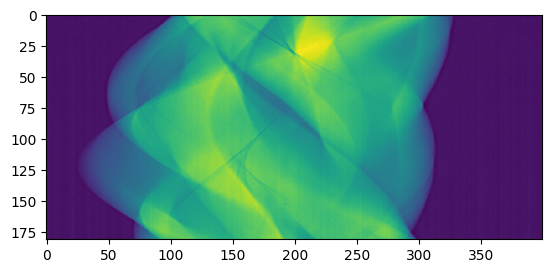

ValueError: padding='same' is not supported for strided convolutions

In [2]:
prj = tifffile.imread('./test_data/tooth.tiff')
nang, px = prj.shape
ang = angles(nang)
prj = nor_tomo(prj)
# prj = np.reshape(prj, (181, 1, 400))
plt.imshow(prj)
plt.show()
rec = GANtomo(prj, ang, iter_num=1000).recon()
plt.imshow(rec)
plt.show()
tifffile.imwrite('./test_results/recon_tooth', rec)

# Reconstruct the data with the ganrec algorithm

# Test for ganrec torch

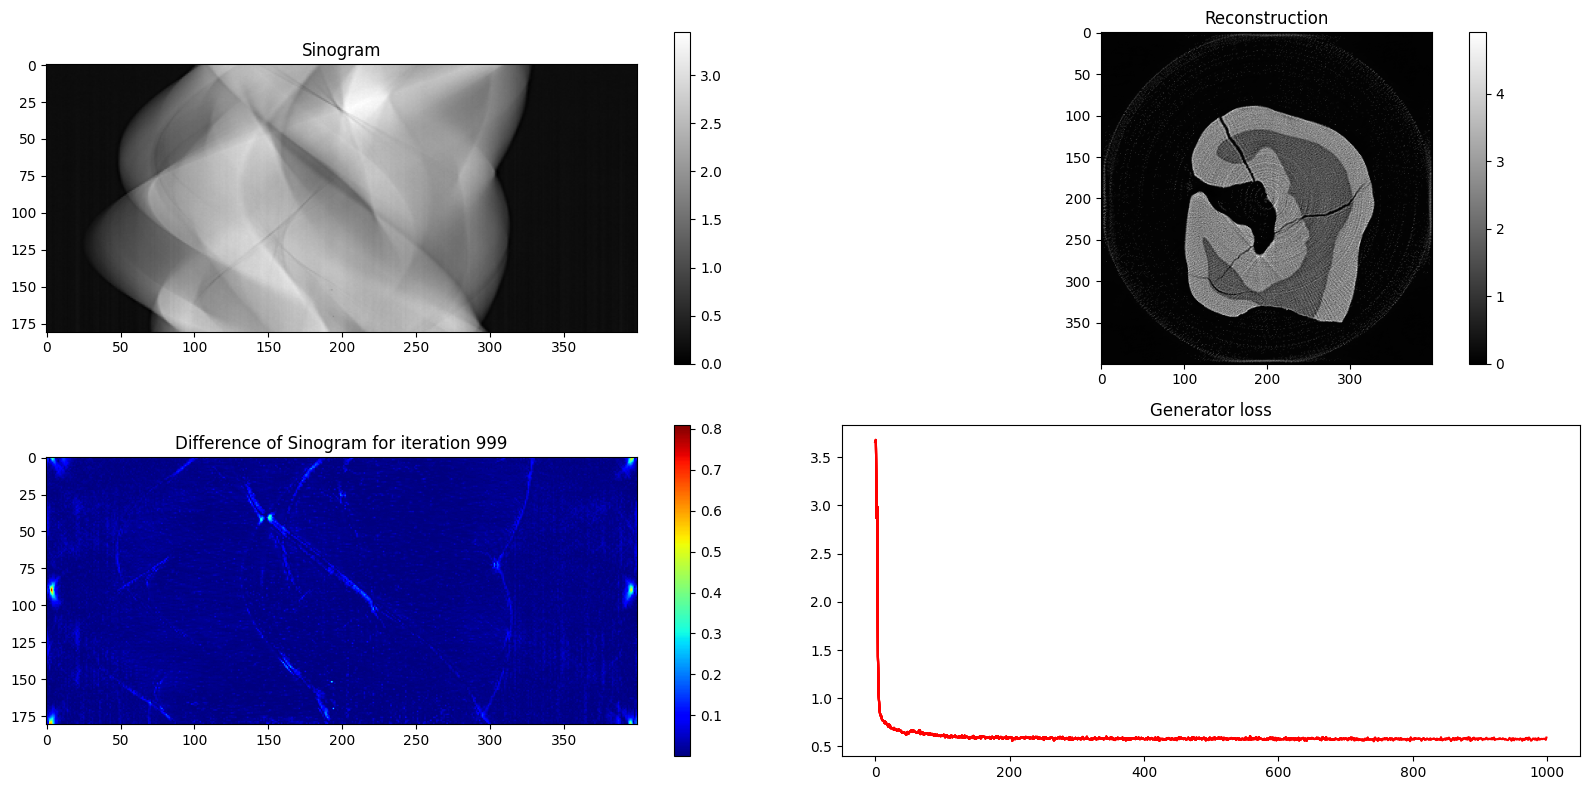

Iteration 1000: G_loss is 0.5923973917961121 and D_loss is 1.5235414505004883


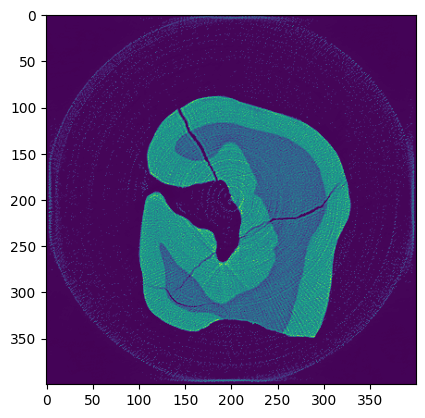


  _     ._   __/__   _ _  _  _ _/_   Recorded: 11:26:56  Samples:  41963
 /_//_/// /_\ / //_// / //_'/ //     Duration: 94.790    CPU time: 93.095
/   _/                      v4.6.2

Program: /nsls2/users/xyang4/conda_envs/ganrec/lib/python3.11/site-packages/ipykernel_launcher.py --f=/nsls2/users/xyang4/.local/share/jupyter/runtime/kernel-v2-3372429r4cU97f98F1k.json

94.789 <module>  ../../../../../tmp/ipykernel_1095820/1914615220.py:1
└─ 94.648 GANtomo.recon  ../ganrectorch/ganrec.py:168
   ├─ 88.289 _fn  torch/_dynamo/eval_frame.py:428
   │  └─ 88.245 GANtomo.recon_step  ../ganrectorch/ganrec.py:136
   │     └─ 88.195 torch_dynamo_resume_in_recon_step_at_138  ../ganrectorch/ganrec.py:138
   │        ├─ 79.700 torch_dynamo_resume_in_recon_step_at_139  ../ganrectorch/ganrec.py:139
   │        │  ├─ 46.216 torch_dynamo_resume_in_recon_step_at_147  ../ganrectorch/ganrec.py:147
   │        │  │  ├─ 44.658 torch_dynamo_resume_in_recon_step_at_149  ../ganrectorch/ganrec.py:149
   │        

In [1]:
from pyinstrument import Profiler
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from ganrectorch.utils import angles, nor_tomo
from ganrectorch.ganrec import GANtomo
profiler = Profiler()
profiler.start()
prj = tifffile.imread('./test_data/tooth.tiff')
nang, px = prj.shape
ang = angles(nang)
prj = nor_tomo(prj)
rec = GANtomo(prj, ang, iter_num=1000).recon()
plt.imshow(rec)
plt.show()
tifffile.imwrite('./test_results/recon_tooth', rec)
profiler.stop()
    
    # Print the profiling results 
print(profiler.output_text(unicode=True, color=True))

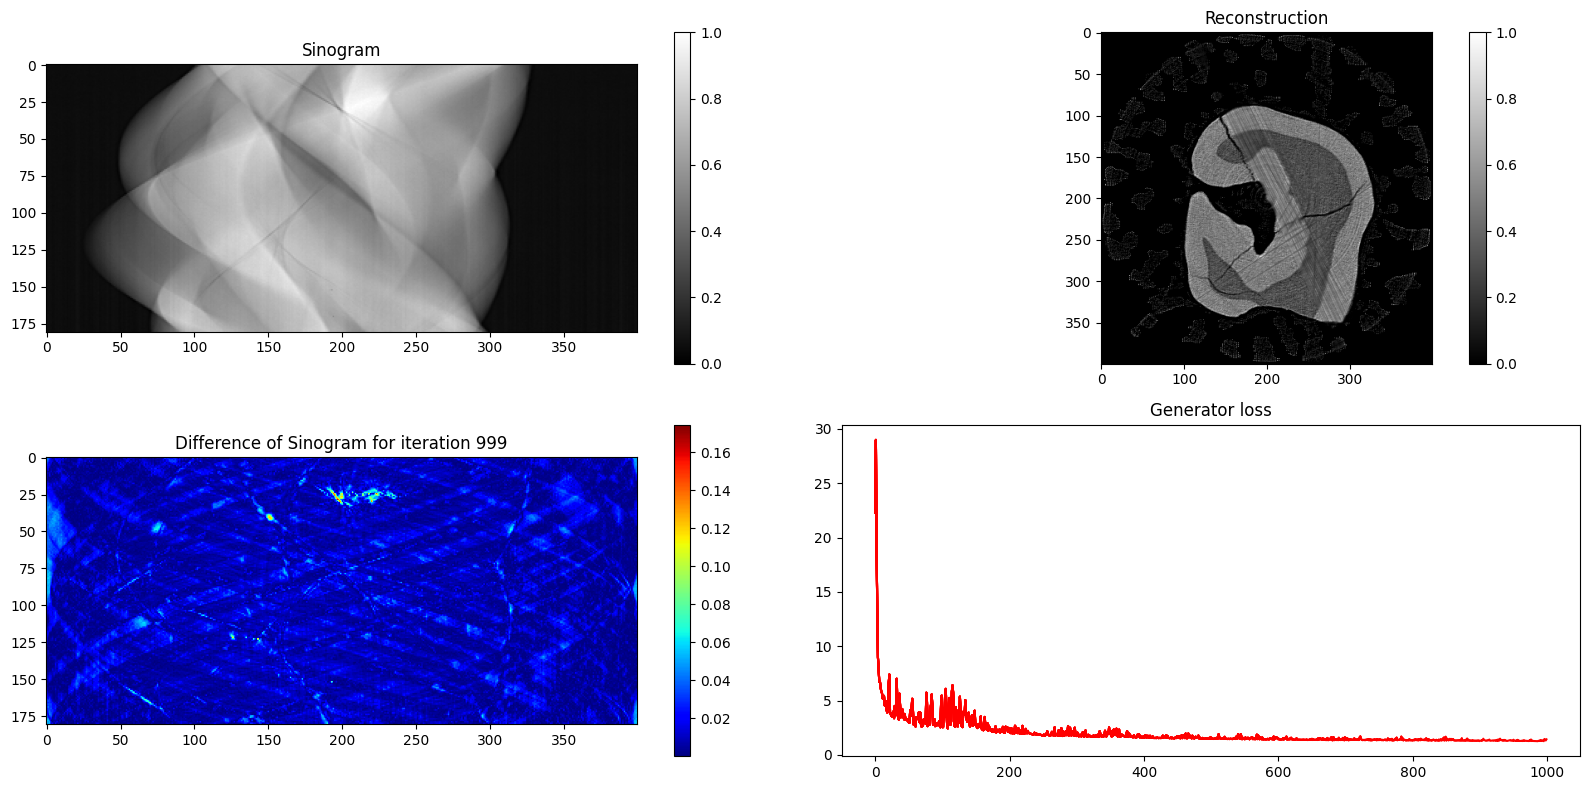

Iteration 1000: G_loss is 1.44009268283844 and D_loss is 1.476864218711853


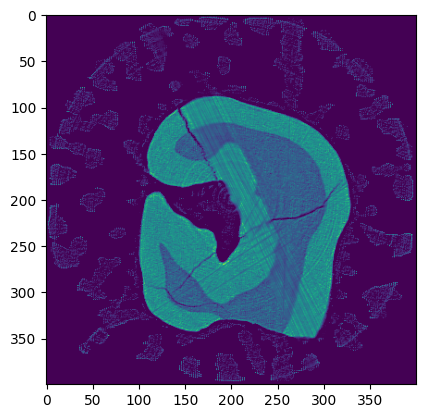


  _     ._   __/__   _ _  _  _ _/_   Recorded: 09:29:33  Samples:  30462
 /_//_/// /_\ / //_// / //_'/ //     Duration: 62.914    CPU time: 62.885
/   _/                      v4.6.2

Program: /nsls2/users/xyang4/conda_envs/ganrec/lib/python3.11/site-packages/ipykernel_launcher.py --f=/nsls2/users/xyang4/.local/share/jupyter/runtime/kernel-v2-3372429dmMAi7nlAs7H.json

62.913 <module>  ../../../../../tmp/ipykernel_3592255/37615212.py:1
└─ 62.771 GANtomo.recon  ../ganrectorch/ganrec.py:134
   ├─ 32.749 _fn  torch/_dynamo/eval_frame.py:428
   │  └─ 32.748 GANtomo.recon_step  ../ganrectorch/ganrec.py:111
   │     └─ 32.734 torch_dynamo_resume_in_recon_step_at_113  ../ganrectorch/ganrec.py:113
   │        ├─ 30.043 torch_dynamo_resume_in_recon_step_at_114  ../ganrectorch/ganrec.py:114
   │        │  ├─ 24.455 torch_dynamo_resume_in_recon_step_at_117  ../ganrectorch/ganrec.py:117
   │        │  │  ├─ 17.510 torch_dynamo_resume_in_recon_step_at_124  ../ganrectorch/ganrec.py:124
   │        │ 

In [2]:
from pyinstrument import Profiler
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from ganrectorch.utils import angles, nor_tomo
from ganrectorch.ganrec import GANtomo
profiler = Profiler()
profiler.start()
prj = tifffile.imread('./test_data/tooth.tiff')
nang, px = prj.shape
ang = angles(nang)
prj = nor_tomo(prj)
rec = GANtomo(prj, ang, iter_num=1000).recon()
plt.imshow(rec)
plt.show()
tifffile.imwrite('./test_results/recon_tooth', rec)
profiler.stop()
    
    # Print the profiling results 
print(profiler.output_text(unicode=True, color=True))


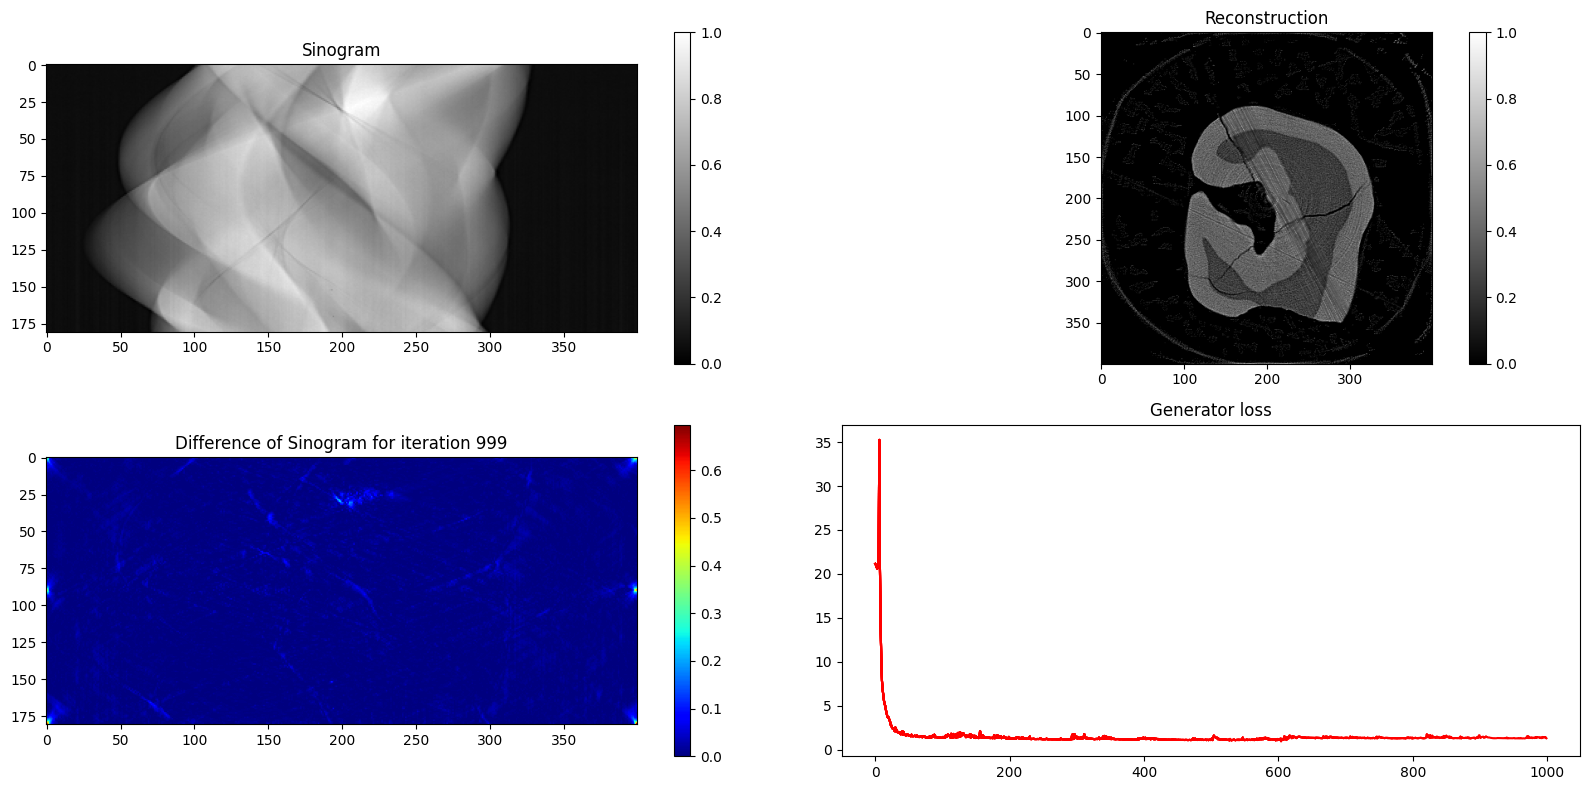

Iteration 1000: G_loss is 1.2879925966262817 and D_loss is 0.8234661221504211


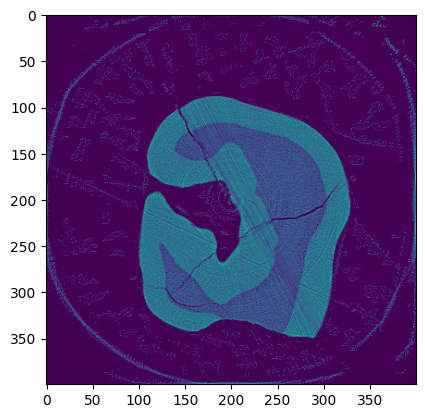


  _     ._   __/__   _ _  _  _ _/_   Recorded: 11:20:27  Samples:  34370
 /_//_/// /_\ / //_// / //_'/ //     Duration: 64.845    CPU time: 63.647
/   _/                      v4.6.2

Program: /nsls2/users/xyang4/conda_envs/ganrec/lib/python3.11/site-packages/ipykernel_launcher.py --f=/nsls2/users/xyang4/.local/share/jupyter/runtime/kernel-v2-3372429QPQu4dz8AwIe.json

64.844 <module>  ../../../../../tmp/ipykernel_3697580/3107405088.py:1
└─ 64.711 GANtomo.recon  ../ganrectorch/ganrec.py:190
   ├─ 58.408 _fn  torch/_dynamo/eval_frame.py:428
   │     [43 frames hidden]  torch, contextlib
   │        56.677 GANtomo.recon_step  ../ganrectorch/ganrec.py:160
   │        └─ 56.636 torch_dynamo_resume_in_recon_step_at_162  ../ganrectorch/ganrec.py:162
   │           ├─ 46.969 torch_dynamo_resume_in_recon_step_at_163  ../ganrectorch/ganrec.py:163
   │           │  ├─ 42.814 torch_dynamo_resume_in_recon_step_at_171  ../ganrectorch/ganrec.py:171
   │           │  │  ├─ 41.119 torch_dynamo_resume_i

In [1]:
from pyinstrument import Profiler
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from ganrectorch.utils import angles, nor_tomo
from ganrectorch.ganrec import GANtomo
profiler = Profiler()
profiler.start()
prj = tifffile.imread('./test_data/tooth.tiff')
nang, px = prj.shape
ang = angles(nang)
prj = nor_tomo(prj)
rec = GANtomo(prj, ang, iter_num=1000, g_learning_rate=1e-2, d_learning_rate=1e-3).recon()
plt.imshow(rec)
plt.show()
tifffile.imwrite('./test_results/recon_tooth', rec)
profiler.stop()
    
    # Print the profiling results 
print(profiler.output_text(unicode=True, color=True))